In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


In [2]:
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd


import libpysal as ps
from libpysal  import weights
from libpysal.weights import Queen

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

from giddy.directional import Rose

import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error 

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import warnings
warnings.filterwarnings('ignore') 
import time

In [3]:
analysis_df=pd.read_csv("C:/Users/NGong/OneDrive - Eastside Preparatory School/Documents/IS stuff/SPD_Crime_Data__2008-Present_20240914.csv")
print(analysis_df.head())

  Report Number   Offense ID  Offense Start DateTime    Offense End DateTime   
0   2020-044620  12605873663  02/05/2020 10:10:00 AM                     NaN  \
1   2020-044452  12605598696  02/03/2020 08:00:00 AM  02/04/2020 08:00:00 AM   
2   2020-044465  12605567653  02/02/2020 08:30:00 PM  02/02/2020 09:30:00 PM   
3   2020-044225  12605174036  02/05/2020 01:17:00 AM  02/05/2020 02:21:00 AM   
4   2020-044076  12605081469  02/05/2020 12:51:21 AM                     NaN   

          Report DateTime Group A B Crime Against Category   
0  02/05/2020 11:24:31 AM         A                SOCIETY  \
1  02/05/2020 10:06:28 AM         A               PROPERTY   
2  02/05/2020 09:39:33 AM         A               PROPERTY   
3  02/05/2020 03:30:55 AM         A               PROPERTY   
4  02/05/2020 12:51:31 AM         B                SOCIETY   

                       Offense Parent Group   
0                    DRUG/NARCOTIC OFFENSES  \
1                             LARCENY-THEFT   
2    

In [4]:
date_time_df=analysis_df[['Precinct','Sector','Beat','MCPP','Offense Start DateTime','Offense End DateTime','Report DateTime','Offense','Longitude','Latitude']]

In [5]:
date_time_df['Offense Start DateTime'] = date_time_df['Offense Start DateTime'].replace('', pd.NA).fillna(date_time_df['Offense End DateTime'])

In [6]:
PM_checker=date_time_df['Offense Start DateTime'].str.contains('PM')
print(PM_checker)

0          False
1          False
2           True
3          False
4          False
           ...  
1144384    False
1144385     True
1144386    False
1144387     True
1144388     True
Name: Offense Start DateTime, Length: 1144389, dtype: object


In [7]:
date_time_df['Offense Start DateTime']=pd.to_datetime(date_time_df['Offense Start DateTime'],format='mixed')

In [8]:
date_time_df['Offense End DateTime']=pd.to_datetime(date_time_df['Offense End DateTime'],errors='coerce',format='mixed')

In [9]:
date_time_df['Report DateTime']=pd.to_datetime(date_time_df['Report DateTime'],format='mixed')

In [10]:
print(date_time_df)
print(date_time_df.dtypes)

        Precinct   Sector     Beat               MCPP Offense Start DateTime   
0              W        Q       Q1           MAGNOLIA    2020-02-05 10:10:00  \
1              N        J       J3  ROOSEVELT/RAVENNA    2020-02-03 08:00:00   
2              N        U       U3  ROOSEVELT/RAVENNA    2020-02-02 20:30:00   
3              W        Q       Q1           MAGNOLIA    2020-02-05 01:17:00   
4              N        B       B2      BALLARD SOUTH    2020-02-05 00:51:21   
...          ...      ...      ...                ...                    ...   
1144384      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-07 00:00:00   
1144385      OOJ       99       99            UNKNOWN    2008-01-07 12:00:00   
1144386      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-08 02:14:00   
1144387      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-02 20:53:00   
1144388      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-02 20:53:00   

        Offense End DateTime     Report

In [11]:
#Redoing this for other NAs
date_time_df['Offense Start DateTime'] = date_time_df['Offense Start DateTime'].replace('', pd.NA).fillna(date_time_df['Offense End DateTime'])

In [12]:
date_time_df['Hour']=date_time_df['Offense Start DateTime'].dt.hour
date_time_df['Minute']=date_time_df['Offense Start DateTime'].dt.minute
print(date_time_df['Hour'])

0          10.0
1           8.0
2          20.0
3           1.0
4           0.0
           ... 
1144384     0.0
1144385    12.0
1144386     2.0
1144387    20.0
1144388    20.0
Name: Hour, Length: 1144389, dtype: float64


In [13]:
date_time_df['Month']=date_time_df['Offense Start DateTime'].dt.month
date_time_df['Year']=date_time_df['Offense Start DateTime'].dt.year

In [14]:
print(date_time_df['Month'])
print((date_time_df['Hour'] == 12).sum())

0          2.0
1          2.0
2          2.0
3          2.0
4          2.0
          ... 
1144384    1.0
1144385    1.0
1144386    1.0
1144387    1.0
1144388    1.0
Name: Month, Length: 1144389, dtype: float64
65523


In [15]:
#Dropping all NAs in both the PM_checker and in the original dataframe
NaNpositions=date_time_df.isna()
print(NaNpositions)
NaNindices=NaNpositions.stack()
nan_indexes = NaNindices[NaNindices].index
rows_with_nan = set(idx[0] for idx in nan_indexes)
df_dropped_rows = date_time_df.drop(index=rows_with_nan)
other_array_dropped_rows = np.delete(PM_checker, list(rows_with_nan), axis=0)

         Precinct  Sector   Beat   MCPP  Offense Start DateTime   
0           False   False  False  False                   False  \
1           False   False  False  False                   False   
2           False   False  False  False                   False   
3           False   False  False  False                   False   
4           False   False  False  False                   False   
...           ...     ...    ...    ...                     ...   
1144384     False   False  False  False                   False   
1144385     False   False  False  False                   False   
1144386     False   False  False  False                   False   
1144387     False   False  False  False                   False   
1144388     False   False  False  False                   False   

         Offense End DateTime  Report DateTime  Offense  Longitude  Latitude   
0                        True            False    False      False     False  \
1                       False      

In [16]:
print(date_time_df)
print(PM_checker)

        Precinct   Sector     Beat               MCPP Offense Start DateTime   
0              W        Q       Q1           MAGNOLIA    2020-02-05 10:10:00  \
1              N        J       J3  ROOSEVELT/RAVENNA    2020-02-03 08:00:00   
2              N        U       U3  ROOSEVELT/RAVENNA    2020-02-02 20:30:00   
3              W        Q       Q1           MAGNOLIA    2020-02-05 01:17:00   
4              N        B       B2      BALLARD SOUTH    2020-02-05 00:51:21   
...          ...      ...      ...                ...                    ...   
1144384      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-07 00:00:00   
1144385      OOJ       99       99            UNKNOWN    2008-01-07 12:00:00   
1144386      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-08 02:14:00   
1144387      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-02 20:53:00   
1144388      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-02 20:53:00   

        Offense End DateTime     Report

In [17]:
date_time_df['Hour'] = pd.to_numeric(date_time_df['Hour'], errors='coerce').astype('Int64') 
date_time_df['Minute'] = pd.to_numeric(date_time_df['Minute'], errors='coerce').astype('Int64') 

In [18]:
add_condition=date_time_df['Minute']>=30
date_time_df.loc[add_condition,'Hour']+=1
maxTimeCondition=date_time_df['Hour']==24
date_time_df.loc[maxTimeCondition,'Hour']-=24

In [19]:
# Count the number of rows where 'A' equals the value
numberCounterArray=np.arange(24)
HourSumArray=np.arange(24)
for i in range(24):
    HourSumArray[i] = (date_time_df['Hour'] == i).sum()

In [20]:
print(HourSumArray)

[103529  40196  36910  26965  22317  19558  19671  23836  35988  37284
  39197  39336  64052  48334  49023  53748  56090  62566  65546  59960
  63267  60505  61822  52969]


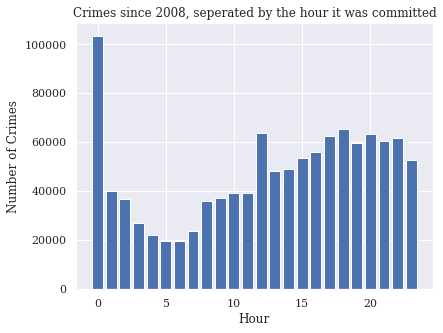

In [21]:
# Create a bar graph
plt.bar(numberCounterArray, HourSumArray)

# Add title and labels
plt.title('Crimes since 2008, seperated by the hour it was committed')
plt.xlabel('Hour')
plt.ylabel('Number of Crimes')

# Show the plot
plt.show()

In [22]:
violentCrimesArray=['Homicide','Rape','Robbery','Aggraved Assault']
violentCrime_df=date_time_df[date_time_df['Offense'].isin(violentCrimesArray)]

In [23]:
pettyTheftCrimesArray=['Theft From Building','Theft From Coin-Operated Machine or Device','Theft From Motor Vehicle', 'Thefts of Motor Vehicle Parts or Accessories','Shoplifting','Pocket-picking','Stolen Property Offenses','All Other Larceny','Purse-snatching']
pettyPropertyCrimesArray=['Destruction/Damage/Vandalism of Property','Trespass of Real Property']
pettyCrimesArray=['Curfew/Loitering/Vagrancy Violations']
pettyScaryCrimesArray=['Drug Equipment Violations','Drug/Narcotic Violations','Drunkness','Kidnapping/Abduction','Weapon Violation Laws']
pettyViolentCrimesArray=['Intimidation','Simple Assault']
#propertyCrimesArray=['Arson','Burglary','Larceny-Theft','Motor Vehicle Theft']


In [24]:
violentCrime_HourSumArray=np.arange(24)
for i in range(24):
    violentCrime_HourSumArray[i] = (violentCrime_df['Hour'] == i).sum()

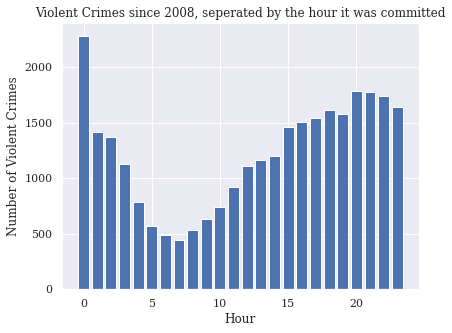

In [25]:
# Create a bar graph
plt.bar(numberCounterArray, violentCrime_HourSumArray)

# Add title and labels
plt.title('Violent Crimes since 2008, seperated by the hour it was committed')
plt.xlabel('Hour')
plt.ylabel('Number of Violent Crimes')

# Show the plot
plt.show()

In [26]:
propertyCrimesArray=['Arson','Burglary','Larceny-Theft','Motor Vehicle Theft']
propertyCrime_df=date_time_df[date_time_df['Offense'].isin(propertyCrimesArray)]

In [27]:
propertyCrime_HourSumArray=np.arange(24)
for i in range(24):
    propertyCrime_HourSumArray[i] = (propertyCrime_df['Hour'] == i).sum()

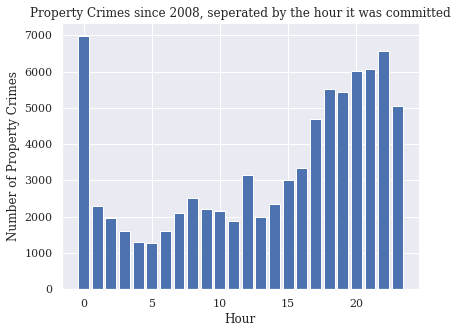

In [28]:
# Create a bar graph
plt.bar(numberCounterArray, propertyCrime_HourSumArray)

# Add title and labels
plt.title('Property Crimes since 2008, seperated by the hour it was committed')
plt.xlabel('Hour')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

In [29]:
monthCounterArray=np.arange(13)
aggregateCrime_MonthSumArray=np.arange(13)
violentCrime_MonthSumArray=np.arange(13)
propertyCrime_MonthSumArray=np.arange(13)
for i in range(13):
    propertyCrime_MonthSumArray[i] = (propertyCrime_df['Month'] == i).sum()
    aggregateCrime_MonthSumArray[i]=(date_time_df['Month']==i).sum()
    violentCrime_MonthSumArray[i]=(violentCrime_df['Month']==i).sum()

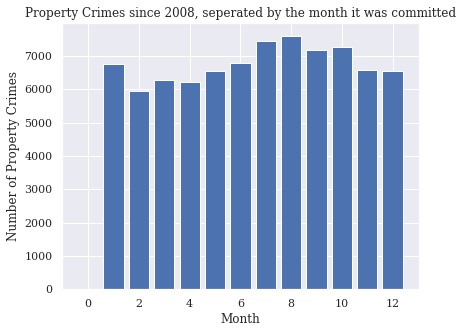

In [30]:
# Create a bar graph
plt.bar(monthCounterArray, propertyCrime_MonthSumArray)

# Add title and labels
plt.title('Property Crimes since 2008, seperated by the month it was committed')
plt.xlabel('Month')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

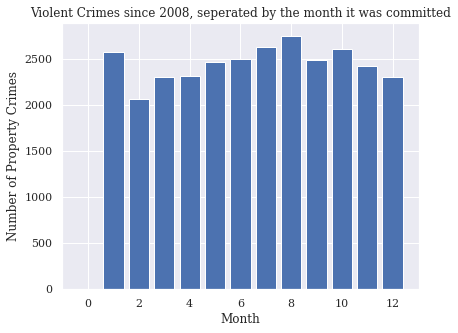

In [31]:
# Create a bar graph
plt.bar(monthCounterArray, violentCrime_MonthSumArray)

# Add title and labels
plt.title('Violent Crimes since 2008, seperated by the month it was committed')
plt.xlabel('Month')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

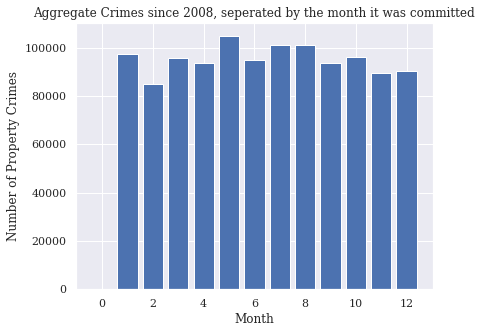

In [32]:
# Create a bar graph
plt.bar(monthCounterArray, aggregateCrime_MonthSumArray)

# Add title and labels
plt.title('Aggregate Crimes since 2008, seperated by the month it was committed')
plt.xlabel('Month')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

In [33]:
yearCounterArray=np.arange(18)
aggregateCrime_YearSumArray=np.arange(18)
violentCrime_YearSumArray=np.arange(18)
propertyCrime_YearSumArray=np.arange(18)
for i in range(17):
    yearCounterArray[i]=i+2007
    propertyCrime_YearSumArray[i] = (propertyCrime_df['Year'] ==yearCounterArray[i]).count()
    aggregateCrime_YearSumArray[i]=(date_time_df['Year']==yearCounterArray[i]).count()
    violentCrime_YearSumArray[i]=(violentCrime_df['Year']==yearCounterArray[i]).count()

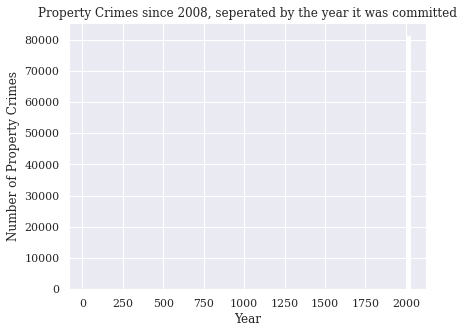

In [34]:
# Create a bar graph
plt.bar(yearCounterArray, propertyCrime_YearSumArray)

# Add title and labels
plt.title('Property Crimes since 2008, seperated by the year it was committed')
plt.xlabel('Year')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

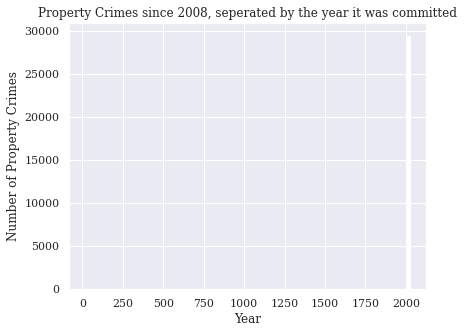

In [35]:
# Create a bar graph
plt.bar(yearCounterArray, violentCrime_YearSumArray)

# Add title and labels
plt.title('Property Crimes since 2008, seperated by the year it was committed')
plt.xlabel('Year')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

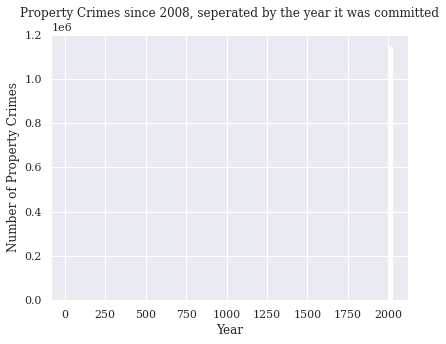

In [36]:
# Create a bar graph
plt.bar(yearCounterArray, aggregateCrime_YearSumArray)

# Add title and labels
plt.title('Property Crimes since 2008, seperated by the year it was committed')
plt.xlabel('Year')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

In [37]:
#MCPP filters
MCPPFilter=['Bitterlake','Queen Anne','Northgate','Pioneer Square','Ballard South','Belltown','Downtown Commercial','First Hill','Chinatown/International District']
MCPPFilterCondition=date_time_df['MCPP'].isin(MCPPFilter)
#Precinct filters
PrecinctFilter=['E','W','N']
PrecinctFilterCondition=date_time_df['Precinct'].isin(PrecinctFilter)
#beat filters
BeatFilter=['K3','E3','D3','D1','M1','K1','B1','B3','N2','Q3']
BeatFilterCondition=date_time_df['Beat'].isin(BeatFilter)
#sector filters
SectorFilter=['N','Q','K','B','D','M','E']
SectorFilterCondition=date_time_df['Sector'].isin(SectorFilter)


In [346]:
txtfile=open("C:/Users/NGong/OneDrive - Eastside Preparatory School/Documents/IS stuff/toftTerrace.txt","r")
with txtfile as file:
    lines=file.readlines()
startFilter=lines[0]
startFilter = startFilter[:-1]
endFilter=lines[1]
endFilter = endFilter[:-1]
latitude=lines[2]
latitude=latitude[:-1]
longitude=lines[3]
longitude=longitude[:-1]
HundredsMeterRadius=lines[4]
timeFrequency=lines[5]
timeFrequency=timeFrequency[:-1]
crimeType=lines[6]
crimeType = crimeType[:-1]
homelessShelterName=lines[7]
MCPP=lines[8]
MCPP=MCPP[:-1]
Precinct=lines[9]
Precinct=Precinct[:-1]
Beat=lines[10]
Beat=Beat[:-1]
Sector=lines[11]
Sector=Sector[:-1]
AnalysisLocator=lines[12]
AnalysisLocator=AnalysisLocator[:-1]
homelessShelterCreation=lines[13]
homelessShelterCreation=homelessShelterCreation[:-1]
startFilter=pd.to_datetime(startFilter)
endFilter=pd.to_datetime(endFilter)
homelessShelterCreation=pd.to_datetime(homelessShelterCreation)
latitude=float(latitude)
longitude=float(longitude)
HundredsMeterRadius=int(HundredsMeterRadius)
timeFrequency=str(timeFrequency)
print(lines)

['2015-09-01\n', '2019-09-01\n', '47.605620\n', '-122.327440\n', '20\n', 'month\n', 'aggregate\n', 'Plymouth First Hill\n', 'First Hill\n', 'E\n', 'E3\n', 'E\n', 'beat\n', '2017-9-01\n']


In [347]:
date_time_df['Violent Crimes']=date_time_df['Offense'].where(date_time_df['Offense'].isin(violentCrimesArray))
date_time_df['Property Crimes']=date_time_df['Offense'].where(date_time_df['Offense'].isin(propertyCrimesArray))
date_time_df['Petty Crimes']=date_time_df['Offense'].where(date_time_df['Offense'].isin(pettyCrimesArray))
date_time_df['Petty Property Crimes']=date_time_df['Offense'].where(date_time_df['Offense'].isin(pettyPropertyCrimesArray))
date_time_df['Petty Scary Crimes']=date_time_df['Offense'].where(date_time_df['Offense'].isin(pettyScaryCrimesArray))
date_time_df['Petty Theft Crimes']=date_time_df['Offense'].where(date_time_df['Offense'].isin(pettyTheftCrimesArray))
date_time_df['Petty Violent Crimes']=date_time_df['Offense'].where(date_time_df['Offense'].isin(pettyViolentCrimesArray))

In [348]:
meterRadius=False
filteredTime_df=date_time_df[(date_time_df['Offense Start DateTime'] >= startFilter) & (date_time_df['Offense End DateTime'] <= endFilter)]
#DUE TO THE DATA BEING LIMITED EVEN WITHIN 1000 METERS, I AM USING MCPP FOR NOW - THIS WILL BE REINSTATED WHEN I EXPLORE THIS AT HIGHER RADII
if AnalysisLocator=='meters':
    LocationLatitudeCondition=(date_time_df['Latitude']>=latitude-HundredsMeterRadius/2882) & (date_time_df['Latitude']<=latitude+HundredsMeterRadius/2882)
    LocationLongitudeCondition=(date_time_df['Longitude']>=longitude-HundredsMeterRadius/2882) & (date_time_df['Longitude']<=longitude+HundredsMeterRadius/2882)
    LocationCondition=LocationLatitudeCondition&LocationLongitudeCondition
    LocationTime_df=filteredTime_df[LocationCondition]
    meterRadius=True
if AnalysisLocator=='MCPP':
    MCPPFilterCondition=filteredTime_df['MCPP']==MCPP
    LocationTime_df=filteredTime_df[MCPPFilterCondition]
    locationPrinter="the MCPP "+MCPP
if AnalysisLocator=='precinct':
    PrecinctFilterCondition=filteredTime_df['Precinct']==Precinct
    LocationTime_df=filteredTime_df[PrecinctFilterCondition]
    locationPrinter="the precinct "+Precinct
if AnalysisLocator=='beat':
    BeatFilterCondition=filteredTime_df['Beat']==Beat
    LocationTime_df=filteredTime_df[BeatFilterCondition]
    locationPrinter="the beat "+Beat
if AnalysisLocator=='sector':
    SectorFilterCondition=filteredTime_df['Sector']==Sector
    LocationTime_df=filteredTime_df[SectorFilterCondition]
    locationPrinter="the sector "+Sector

print(LocationTime_df)

        Precinct Sector Beat          MCPP Offense Start DateTime   
3397           E      E   E3  CAPITOL HILL    2019-08-19 12:00:00  \
10089          E      E   E3    FIRST HILL    2019-08-09 12:00:00   
10695          E      E   E3  CAPITOL HILL    2019-08-20 17:00:00   
12190          E      E   E3    FIRST HILL    2019-07-30 00:00:00   
12853          E      E   E3    FIRST HILL    2019-07-19 17:00:00   
...          ...    ...  ...           ...                    ...   
1027274        E      E   E3    FIRST HILL    2018-08-06 01:00:00   
1085982        E      E   E3  CAPITOL HILL    2016-06-14 00:01:00   
1091786        E      E   E3  CAPITOL HILL    2016-07-29 17:30:00   
1142971        E      E   E3  CAPITOL HILL    2019-05-30 18:15:00   
1142975        E      E   E3  CAPITOL HILL    2019-05-21 19:00:00   

        Offense End DateTime     Report DateTime   
3397     2019-08-19 12:00:00 2019-12-31 12:42:10  \
10089    2019-08-10 11:50:00 2019-10-22 10:44:28   
10695    2019-0

In [349]:
# Create a new column for month-year for grouping
if timeFrequency=="month":
    print('JAI SHARMA')
    LocationTime_df['month_year'] = LocationTime_df['Offense Start DateTime'].dt.to_period('M')
    print('super cool')
    print(LocationTime_df)
if timeFrequency=="year":
    LocationTime_df['month_year'] = LocationTime_df['Offense Start DateTime'].dt.to_period('Y')
if timeFrequency=="day":
    LocationTime_df['month_year'] = LocationTime_df['Offense Start DateTime'].dt.to_period('D')
else:
    print('womp womp')



# Group by month-year and calculate the sum (or mean, count, etc.) of the values
if crimeType=='violent':
    print('violent')
    LocationTime_df=LocationTime_df.dropna(subset=["Violent Crimes"])
    monthly_crimes = LocationTime_df.groupby('month_year').size().reset_index(name='Violent Crimes')
    plotter=monthly_crimes["Violent Crimes"]
if crimeType=='property': 
    print('property')   
    LocationTime_df=LocationTime_df.dropna(subset=["Property Crimes"])
    monthly_crimes = LocationTime_df.groupby('month_year').size().reset_index(name='Property Crimes')
    plotter=monthly_crimes["Property Crimes"]
if crimeType=='aggregate':
    print('aggregate')
    monthly_crimes = LocationTime_df.groupby('month_year').size().reset_index(name='Offense')
    plotter=monthly_crimes["Offense"]
if crimeType=='petty':
    LocationTime_df=LocationTime_df.dropna(subset=["Petty Crimes"])
    monthly_crimes = LocationTime_df.groupby('month_year').size().reset_index(name='Petty Crimes')
    plotter=monthly_crimes["Petty Crimes"]
if crimeType=='petty property':
    LocationTime_df=LocationTime_df.dropna(subset=["Petty Property Crimes"])
    monthly_crimes = LocationTime_df.groupby('month_year').size().reset_index(name='Petty Property Crimes')
    plotter=monthly_crimes["Petty Property Crimes"]
if crimeType=='petty scary':
    LocationTime_df=LocationTime_df.dropna(subset=["Petty Scary Crimes"])
    monthly_crimes = LocationTime_df.groupby('month_year').size().reset_index(name='Petty Scary Crimes')
    plotter=monthly_crimes["Petty Scary Crimes"]
if crimeType=='petty theft':
    LocationTime_df=LocationTime_df.dropna(subset=["Petty Theft Crimes"])
    monthly_crimes = LocationTime_df.groupby('month_year').size().reset_index(name='Petty Theft Crimes')
    plotter=monthly_crimes["Petty Theft Crimes"]
if crimeType=='petty violent':
    LocationTime_df=LocationTime_df.dropna(subset=["Petty Violent Crimes"])
    monthly_crimes = LocationTime_df.groupby('month_year').size().reset_index(name='Petty Violent Crimes')
    plotter=monthly_crimes["Petty Violent Crimes"]
print(monthly_crimes)

#making sure that time_crime does have the dropped values for months where there are no violent or property crimes
if 'month_year' in LocationTime_df.columns:
    time_crimes = LocationTime_df.groupby('month_year').size().reset_index()
    print(time_crimes.head(5))
else:
    print("The column 'month_year' does not exist.")

#print(monthly_crimes['month_year'])

# Convert month_year back to datetime for plotting. Note that I'm using time_crimes since monthly_crimes becomes goofy with by seperating violent, property, and aggregate offenses
time_crimes['month_year'] = time_crimes['month_year'].dt.to_timestamp()
print(time_crimes['month_year'])
print(type(time_crimes['month_year']))
print(monthly_crimes)



JAI SHARMA
super cool
        Precinct Sector Beat          MCPP Offense Start DateTime   
3397           E      E   E3  CAPITOL HILL    2019-08-19 12:00:00  \
10089          E      E   E3    FIRST HILL    2019-08-09 12:00:00   
10695          E      E   E3  CAPITOL HILL    2019-08-20 17:00:00   
12190          E      E   E3    FIRST HILL    2019-07-30 00:00:00   
12853          E      E   E3    FIRST HILL    2019-07-19 17:00:00   
...          ...    ...  ...           ...                    ...   
1027274        E      E   E3    FIRST HILL    2018-08-06 01:00:00   
1085982        E      E   E3  CAPITOL HILL    2016-06-14 00:01:00   
1091786        E      E   E3  CAPITOL HILL    2016-07-29 17:30:00   
1142971        E      E   E3  CAPITOL HILL    2019-05-30 18:15:00   
1142975        E      E   E3  CAPITOL HILL    2019-05-21 19:00:00   

        Offense End DateTime     Report DateTime   
3397     2019-08-19 12:00:00 2019-12-31 12:42:10  \
10089    2019-08-10 11:50:00 2019-10-22 10:44

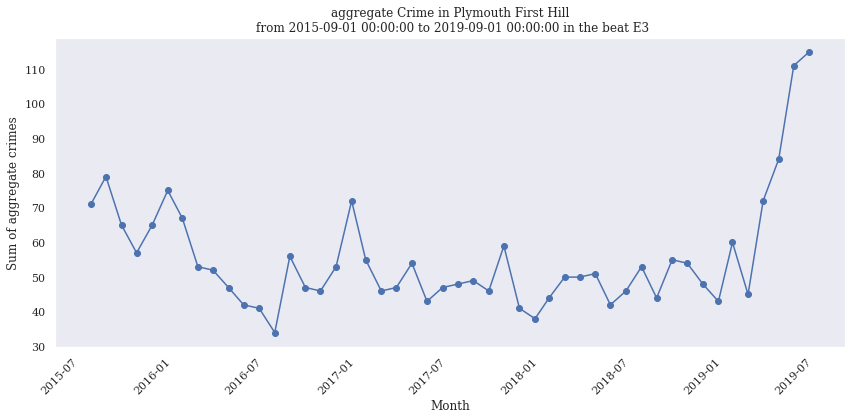

In [350]:
# Plotting
plottingstartFilter=str(startFilter)
plottingendFilter=str(endFilter)
HundredsMeterRadius=str(HundredsMeterRadius)
homelessShelterName=lines[7]
plt.figure(figsize=(12, 6))
plt.plot(time_crimes['month_year'], plotter, marker='o')
if meterRadius==True:
    plt.title(crimeType+' Crime in'+homelessShelterName+'from '+plottingstartFilter+' to ' +plottingendFilter+' within a '+HundredsMeterRadius+'00 meter radius')
else:
    plt.title(crimeType+' Crime in '+homelessShelterName+' from '+plottingstartFilter+' to ' +plottingendFilter+" in "+locationPrinter)
plt.xlabel('Month')
plt.ylabel('Sum of ' +crimeType + ' crimes')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

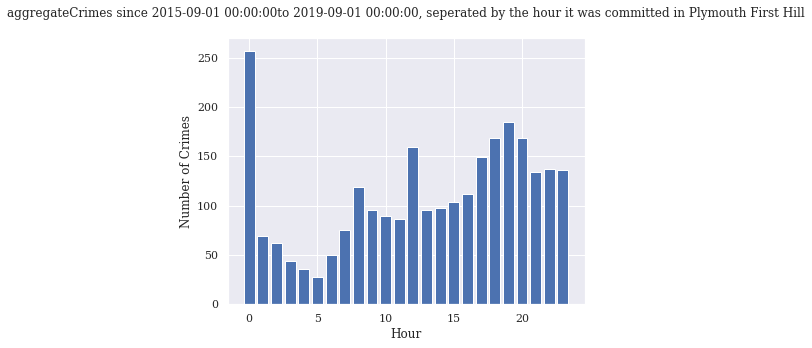

In [351]:
#analysis of crime at time of day, other interesting questions that I analyzed in big dataset -> over here now
#this is by different hours of the day

# Count the number of rows where 'A' equals the value
numberCounterArray=np.arange(24)
LocationTimeAggregateHourSumArray=np.arange(24)
for i in range(24):
    LocationTimeAggregateHourSumArray[i] = (LocationTime_df['Hour'] == i).sum()
    

# Create a bar graph
plt.bar(numberCounterArray, LocationTimeAggregateHourSumArray)

# Add title and labels
if meterRadius==True:
    plt.title('Data of crime in from '+homelessShelterName+' '+plottingstartFilter+' to ' +plottingendFilter+' within a '+HundredsMeterRadius+'00 meter radius')
else:
    plt.title('Data of crime in from '+homelessShelterName+' '+plottingstartFilter+' to ' +plottingendFilter+" in "+locationPrinter)

plt.title(crimeType+'Crimes since '+plottingstartFilter +'to '+plottingendFilter+', seperated by the hour it was committed in '+homelessShelterName)
plt.xlabel('Hour')
plt.ylabel('Number of Crimes')

# Show the plot
plt.show()

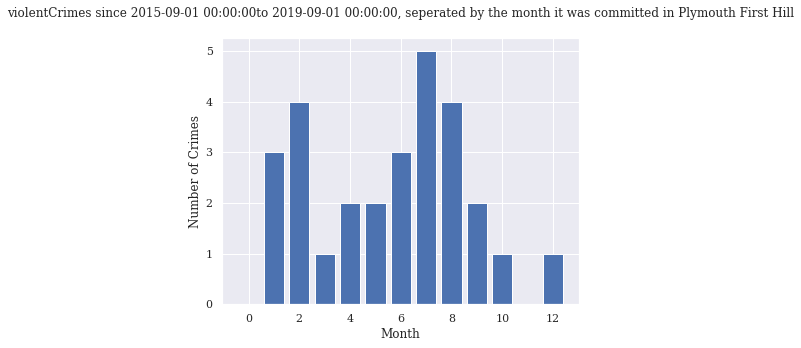

In [342]:
monthCounterArray=np.arange(13)
LocationTimeCrime_MonthSumArray=np.arange(13)
for i in range(13):
    LocationTimeCrime_MonthSumArray[i] = (LocationTime_df['Month'] == i).sum()

# Create a bar graph
plt.bar(monthCounterArray, LocationTimeCrime_MonthSumArray)

# Add title and labels
plt.title(crimeType+'Crimes since '+plottingstartFilter +'to '+plottingendFilter+', seperated by the month it was committed in '+homelessShelterName)
plt.xlabel('Month')
plt.ylabel('Number of Crimes')

# Show the plot
plt.show()

In [343]:
#The actual statistical analysis
annual_crimes = []
for i in range(0, len(plotter), 12):
    # Ensure we don't go out of bounds for the last group
    annual_sum = plotter[i:i+12].sum()
    annual_crimes.append(annual_sum)
print(annual_crimes)

homelessShelterCreation=homelessShelterCreation.year
startFilter=startFilter.year
endFilter=endFilter.year
yearsBeforeCreation=homelessShelterCreation-startFilter
yearsAfterCreation=endFilter-homelessShelterCreation
annual_intCrimes_array=np.array(annual_crimes)

BeforeComparedToRightAfterCreation=annual_crimes[yearsBeforeCreation]/np.mean(annual_crimes[0:yearsBeforeCreation])*100
BeforeComparedToAfterCreation=np.mean(annual_crimes[yearsBeforeCreation:yearsBeforeCreation+yearsAfterCreation])/np.mean(annual_crimes[0:yearsBeforeCreation])*100
RightAfterComparedToAfterCreation=annual_crimes[yearsBeforeCreation]/np.mean(annual_crimes[yearsBeforeCreation:yearsBeforeCreation+yearsAfterCreation])*100


print("After vs Before:"+str(BeforeComparedToAfterCreation)+"% Right after vs Before"+str(BeforeComparedToRightAfterCreation)+"% Right after vs After: "+str(RightAfterComparedToAfterCreation)+"%")
print('# of '+crimeType+' Crimes '+str(yearsBeforeCreation))
if meterRadius==True:
    print("After vs Before:"+str(BeforeComparedToAfterCreation)+"% Right after vs Before"+str(BeforeComparedToRightAfterCreation)+"% Right after vs After: "+str(RightAfterComparedToAfterCreation)+"%"+' within a '+HundredsMeterRadius+'00 meter radius')
else:
    print("After vs Before: "+str(BeforeComparedToAfterCreation)+"% Right after vs Before: "+str(BeforeComparedToRightAfterCreation)+"% Right after vs After: "+str(RightAfterComparedToAfterCreation)+"%"+" in "+locationPrinter)


[15, 13]


IndexError: list index out of range

In [344]:
# FILTEREDTIME DF - Finding the crimes in SEATTLE (not the location & time filter for this)
# Create a new column for month-year for grouping
if timeFrequency=="month":
    print('JAI SHARMA')
    filteredTime_df['month_year'] = filteredTime_df['Offense Start DateTime'].dt.to_period('M')
    print('super cool')
    print(LocationTime_df)
if timeFrequency=="year":
    filteredTime_df['month_year'] = filteredTime_df['Offense Start DateTime'].dt.to_period('Y')
if timeFrequency=="day":
    filteredTime_df['month_year'] = filteredTime_df['Offense Start DateTime'].dt.to_period('D')
else:
    print('womp womp')



# Group by month-year and calculate the sum (or mean, count, etc.) of the values
if crimeType=='violent':
    print('violent')
    filteredTime_df=filteredTime_df.dropna(subset=["Violent Crimes"])
    monthly_crimes = filteredTime_df.groupby('month_year').size().reset_index(name='Violent Crimes')
    plotter=monthly_crimes["Violent Crimes"]
if crimeType=='property': 
    print('property')   
    filteredTime_df=filteredTime_df.dropna(subset=["Property Crimes"])
    monthly_crimes = filteredTime_df.groupby('month_year').size().reset_index(name='Property Crimes')
    plotter=monthly_crimes["Property Crimes"]
if crimeType=='aggregate':
    print('aggregate')
    monthly_crimes = filteredTime_df.groupby('month_year').size().reset_index(name='Offense')
    plotter=monthly_crimes["Offense"]
if crimeType=='petty':
    filteredTime_df=filteredTime_df.dropna(subset=["Petty Crimes"])
    monthly_crimes = filteredTime_df.groupby('month_year').size().reset_index(name='Petty Crimes')
    plotter=monthly_crimes["Petty Crimes"]
if crimeType=='petty property':
    filteredTime_df=filteredTime_df.dropna(subset=["Petty Property Crimes"])
    monthly_crimes = filteredTime_df.groupby('month_year').size().reset_index(name='Petty Property Crimes')
    plotter=monthly_crimes["Petty Property Crimes"]
if crimeType=='petty scary':
    filteredTime_df=filteredTime_df.dropna(subset=["Petty Scary Crimes"])
    monthly_crimes = filteredTime_df.groupby('month_year').size().reset_index(name='Petty Scary Crimes')
    plotter=monthly_crimes["Petty Scary Crimes"]
if crimeType=='petty theft':
    filteredTime_df=filteredTime_df.dropna(subset=["Petty Theft Crimes"])
    monthly_crimes = filteredTime_df.groupby('month_year').size().reset_index(name='Petty Theft Crimes')
    plotter=monthly_crimes["Petty Theft Crimes"]
if crimeType=='petty violent':
    filteredTime_df=filteredTime_df.dropna(subset=["Petty Violent Crimes"])
    monthly_crimes = filteredTime_df.groupby('month_year').size().reset_index(name='Petty Violent Crimes')
    plotter=monthly_crimes["Petty Violent Crimes"]
print(monthly_crimes)

#making sure that time_crime does have the dropped values for months where there are no violent or property crimes
if 'month_year' in filteredTime_df.columns:
    time_crimes = filteredTime_df.groupby('month_year').size().reset_index()
    print(time_crimes.head(5))
else:
    print("The column 'month_year' does not exist.")

#print(monthly_crimes['month_year'])

# Convert month_year back to datetime for plotting. Note that I'm using time_crimes since monthly_crimes becomes goofy with by seperating violent, property, and aggregate offenses
time_crimes['month_year'] = time_crimes['month_year'].dt.to_timestamp()
print(time_crimes['month_year'])
print(type(time_crimes['month_year']))
print(monthly_crimes)



JAI SHARMA
super cool
       Precinct Sector Beat          MCPP Offense Start DateTime   
16797         E      E   E3    FIRST HILL    2019-08-18 09:34:00  \
16941         E      E   E3    FIRST HILL    2019-08-16 00:14:00   
18400         E      E   E3    FIRST HILL    2019-08-02 18:45:00   
20329         E      E   E3    FIRST HILL    2019-07-15 15:17:00   
22332         E      E   E3    FIRST HILL    2019-06-26 06:15:00   
23332         E      E   E3    FIRST HILL    2019-06-15 12:00:00   
26445         E      E   E3    FIRST HILL    2019-05-15 19:16:00   
55080         E      E   E3    FIRST HILL    2018-08-22 23:00:00   
60050         E      E   E3  CAPITOL HILL    2018-07-28 00:00:00   
73133         E      E   E3    FIRST HILL    2018-05-04 04:00:00   
84336         E      E   E3    FIRST HILL    2018-02-09 17:25:00   
84890         E      E   E3  CAPITOL HILL    2018-02-02 03:00:00   
112127        E      E   E3    FIRST HILL    2017-07-13 02:00:00   
115822        E      E   E

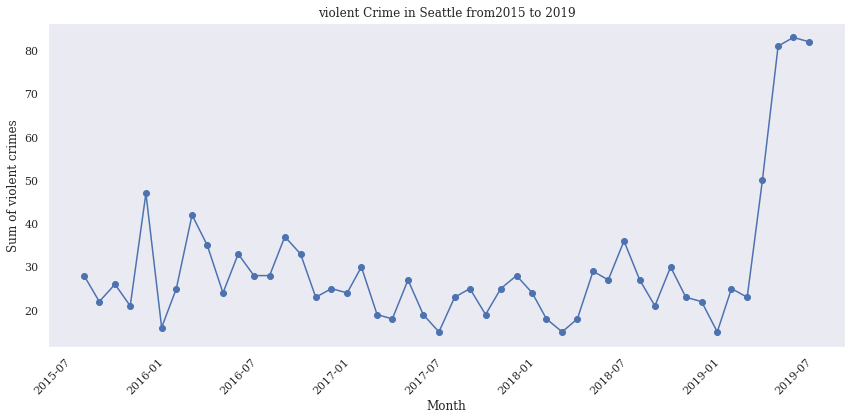

In [333]:
# Plotting
plottingstartFilter=str(startFilter)
plottingendFilter=str(endFilter)
HundredsMeterRadius=str(HundredsMeterRadius)
homelessShelterName=lines[7]
plt.figure(figsize=(12, 6))
plt.plot(time_crimes['month_year'], plotter, marker='o')
if meterRadius==True:
    plt.title(crimeType+' Crime in'+homelessShelterName+'from '+plottingstartFilter+' to ' +plottingendFilter+' within a '+HundredsMeterRadius+'00 meter radius')
else:
    plt.title(crimeType+' Crime in Seattle from'+plottingstartFilter+' to ' +plottingendFilter)
plt.xlabel('Month')
plt.ylabel('Sum of ' +crimeType + ' crimes')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [334]:
#The actual statistical analysis of crime rate within that place vs whole of Seattle
if MCPP=='Capitol Hill':
    population=29343
if MCPP=='University District':
    population=27006
if MCPP=='Magnolia':
    population=18542
if MCPP=='First Hill':
    population=11718
if MCPP=='Belltown':
    population=11067
if MCPP=='Chinatown/International District':
    population=3289
if MCPP=='Bitterlake':
    population=8000
if MCPP=='Ballard':
    population=10121
if MCPP=='Queen Anne':
    population=7172


Seattleannual_crimes = []
for i in range(0, len(plotter), 12):
    # Ensure we don't go out of bounds for the last group
    Seattleannual_sum = plotter[i:i+12].sum()
    Seattleannual_crimes.append(Seattleannual_sum)
print(Seattleannual_crimes)
print(annual_crimes)


yearsBeforeCreation=homelessShelterCreation-startFilter
yearsAfterCreation=endFilter-homelessShelterCreation
annual_intCrimes_array=np.array(annual_crimes)

#actually calculating the crime rate 
SeattlePopulation=668849

crimeRateBeforeCreation=np.mean(annual_crimes[0:yearsBeforeCreation])/population
seatleCrimeRateBeforeCreation=np.mean(Seattleannual_crimes[0:yearsBeforeCreation])/SeattlePopulation
print("Crime Rate Before Creation"+str(crimeRateBeforeCreation)+"Crime Rate in Seattle Before Creation"+str(seatleCrimeRateBeforeCreation))
print(crimeRateBeforeCreation/seatleCrimeRateBeforeCreation*100)

crimeRateRightAfterCreation=annual_crimes[yearsBeforeCreation]/population
seatleCrimeRateRightAfterCreation=Seattleannual_crimes[yearsBeforeCreation]/SeattlePopulation
print("Crime Rate Right After Creation"+str(crimeRateRightAfterCreation)+"Crime Rate in Seattle Right After Creation"+str(seatleCrimeRateRightAfterCreation))
print(crimeRateRightAfterCreation/seatleCrimeRateRightAfterCreation*100)

crimeRateAfterCreation=np.mean(annual_crimes[yearsBeforeCreation:yearsBeforeCreation+yearsAfterCreation])/population
seattleCrimeRateAfterCreation=np.mean(Seattleannual_crimes[yearsBeforeCreation:yearsBeforeCreation+yearsAfterCreation])/population
print("Crime Rate After Creation"+str(crimeRateAfterCreation)+"Crime Rate in Seattle After Creation"+str(seattleCrimeRateAfterCreation))
print(crimeRateAfterCreation/seattleCrimeRateAfterCreation*100)

[347, 298, 287, 482]
[15, 13]
Crime Rate Before Creation0.0011947431302270011Crime Rate in Seattle Before Creation0.0004821716112306365
247.78379780130217


IndexError: list index out of range

In [335]:
if MCPP=='Capitol Hill':
    populationDensity=16512
if MCPP=='University District':
    populationDensity=14561
if MCPP=='Magnolia':
    populationDensity=5045
if MCPP=='First Hill':
    populationDensity=26852
if MCPP=='Belltown':
    populationDensity=37928
if MCPP=='Chinatown/International District':
    populationDensity=15042
if MCPP=='Bitterlake':
    populationDensity=8318
if MCPP=='Ballard':
    populationDensity=12103
if MCPP=='Queen Anne':
    populationDensity=11905

SeattlePopulationDensity=7978

crimeRateBeforeCreation=np.mean(annual_crimes[0:yearsBeforeCreation])/populationDensity
seatleCrimeRateBeforeCreation=np.mean(Seattleannual_crimes[0:yearsBeforeCreation])/SeattlePopulationDensity
print(crimeType+"Crime Rate Before Creation"+str(crimeRateBeforeCreation)+crimeType+"Crime Rate in Seattle Before Creation"+str(seatleCrimeRateBeforeCreation))
print(crimeRateBeforeCreation/seatleCrimeRateBeforeCreation*100)

crimeRateRightAfterCreation=annual_crimes[yearsBeforeCreation]/populationDensity
seatleCrimeRateRightAfterCreation=Seattleannual_crimes[yearsBeforeCreation]/SeattlePopulationDensity
print(crimeType+"Crime Rate Right After Creation"+str(crimeRateRightAfterCreation)+crimeType+"Crime Rate in Seattle Right After Creation"+str(seatleCrimeRateRightAfterCreation))
print(crimeRateRightAfterCreation/seatleCrimeRateRightAfterCreation*100)

crimeRateAfterCreation=np.mean(annual_crimes[yearsBeforeCreation:yearsBeforeCreation+yearsAfterCreation])/populationDensity
seattleCrimeRateAfterCreation=np.mean(Seattleannual_crimes[yearsBeforeCreation:yearsBeforeCreation+yearsAfterCreation])/populationDensity
print(crimeType+"Crime Rate After Creation"+str(crimeRateAfterCreation)+crimeType+"Crime Rate in Seattle After Creation"+str(seattleCrimeRateAfterCreation))
print(crimeRateAfterCreation/seattleCrimeRateAfterCreation*100)

violentCrime Rate Before Creation0.0005213764337851929violentCrime Rate in Seattle Before Creation0.04042366507896716
1.289780213562254


IndexError: list index out of range

In [ ]:
#actually calculating crime rate with respect to population density